In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import os, tqdm, pickle, cv2
import pandas as pd
import seaborn as sns
from PIL import Image
from collections import Counter

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay, average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from skimage.feature import fisher_vector, learn_gmm
# from sklearn.feature_extraction.image import extract_patches_2d

from typing import *
from utils import *

import wandb
os.environ["WANDB_ENTITY"] = "c3-mcv"
wandb.login(key = '14a56ed86de5bf43e377d95d05458ca8f15f5017', relogin=True)

%load_ext autoreload
%autoreload 2

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Luis/.netrc


In [2]:
def histogram_intersection_kernel(X, Y):
    """
    Histogram intersection kernel.
    
    Parameters:
        X: array-like of shape (n_samples_X, n_features)
        Y: array-like of shape (n_samples_Y, n_features)
    
    Returns:
        kernel_matrix: array of shape (n_samples_X, n_samples_Y)
    """
    # Expand dimensions of X and Y for broadcasting
    X_expanded = np.expand_dims(X, 1)
    Y_expanded = np.expand_dims(Y, 0)

    # Compute the minimum between each pair of vectors (broadcasting)
    minima = np.minimum(X_expanded, Y_expanded)

    # Sum over the feature dimension to compute the kernel
    kernel_matrix = np.sum(minima, axis=2)

    return kernel_matrix

def histogram_intersection_distance(X, Y):
    """
    Histogram intersection distance for kNN.
    
    Parameters:
        X: array-like of shape (n_samples_X, n_features)
        Y: array-like of shape (n_samples_Y, n_features)
    
    Returns:
        distance_matrix: array of shape (n_samples_X, n_samples_Y)
    """
    # Calculate the histogram intersection similarity
    similarity = histogram_intersection_kernel(X, Y)
    
    max_similarity = np.minimum(X.sum(axis=1)[:, np.newaxis], Y.sum(axis=1)[np.newaxis, :])
    return 1 - (similarity / max_similarity)

def accuracy(predictions, labels):
    """
    Calculates the accuracy of a set of predictions compared to the actual labels.

    Parameters:
        predictions: numpy array containing the predicted values.
        labels: numpy array containing the actual labels.

    Returns:
        A float representing the accuracy.
    """
    return sum(predictions == labels) / len(labels)

def precision(predictions, labels, class_label):
    """
    Calculates precision for a specific class in a classification task.

    Parameters:
        predictions: numpy array containing the predicted class labels.
        labels: numpy array containing the actual class labels.
        class_label: the specific class for which precision is calculated.

    Returns:
        Precision value for the specified class.
    """
    tp = np.sum((predictions == class_label) & (labels == class_label))
    fp = np.sum((predictions == class_label) & (labels != class_label))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(predictions, labels, class_label):
    """
    Calculates recall for a specific class in a classification task.

    Parameters:
        predictions: numpy array containing the predicted class labels.
        labels: numpy array containing the actual class labels.
        class_label: the specific class for which recall is calculated.

    Returns:
        Recall value for the specified class.
    """
    tp = np.sum((predictions == class_label) & (labels == class_label))
    fn = np.sum((predictions != class_label) & (labels == class_label))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def average_precision(predictions, labels):
    """
    Calculates the average precision across all classes in a classification task.

    Parameters:
        predictions: numpy array containing the predicted class labels.
        labels: numpy array containing the actual class labels.

    Returns:
        The average precision across all classes.
    """
    classes = np.unique(labels)
    return np.mean([precision(predictions, labels, c) for c in classes])

def average_recall(predictions, labels):
    """
    Calculates the average recall across all classes in a classification task.

    Parameters:
        predictions: numpy array containing the predicted class labels.
        labels: numpy array containing the actual class labels.

    Returns:
        The average recall across all classes.
    """
    classes = np.unique(labels)
    return np.mean([recall(predictions, labels, c) for c in classes])

def average_f1(predictions, labels):
    """
    Calculates the average F1 score across all classes in a classification task.

    Parameters:
        predictions: numpy array containing the predicted class labels.
        labels: numpy array containing the actual class labels.

    Returns:
        The average F1 score across all classes.
    """
    
    return 2 * average_precision(predictions, labels) * average_recall(predictions, labels) / (average_precision(predictions, labels) + average_recall(predictions, labels))

def compute_macro_roc_curve(y_onehot_test, y_score):
    """
    Computes the ROC curve and ROC area for each class.
    
    Parameters:
        y_onehot_test: array-like of shape (n_samples, n_classes)
        prob_matrix: array-like of shape (n_samples, n_classes)
    
    Returns:
        fpr_grid: Array of false positive rates at which ROC curves are evaluated.
        mean_tpr: Array of mean true positive rates corresponding to the fpr_grid.
    """
    n_classes = y_onehot_test.shape[1]
    # store the fpr, tpr
    fpr, tpr = dict(), dict()
    fpr_grid = np.linspace(0.0, 1.0, 1000)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    return fpr_grid, mean_tpr / n_classes

def compute_micro_roc_curve(y_onehot_test, y_score):
    """
    Computes the micro ROC curve and ROC area.
    
    Parameters:
        y_onehot_test: array-like of shape (n_samples, n_classes)
        prob_matrix: array-like of shape (n_samples, n_classes)
        
    Returns:
        fpr: Array of false positive rates.
        tpr: Array of true positive rates.
    """
    # Compute micro-average ROC curve
    fpr, tpr, _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())

    return fpr, tpr

In [9]:
class MLP_BoVW():
    def __init__(self, config, model_path, size_per_class=1e9, data_path='./MIT_split'):
        """
        Bag-of-Visual-Words (BoVW) image classifier.

        Parameters:
        - config: Dictionary containing configuration parameters for the BoVW model.
        - size_per_class: Maximum number of images per class to use for training.
        - data_path: Path to the dataset folder.
        """
        self.config = config
        self.size_per_class = size_per_class
        self.data_path = data_path
        self._initialize_datasets()

        # Compute features for each split
        self.train_features = self._compute_features(self.train_dataset_blocks['image_paths'], 'train', model_path)
        self.test_features = self._compute_features(self.test_dataset_blocks['image_paths'], 'test', model_path)

        # Classification
        if self.config['classifier'] == 'knn':
            self.classifier = KNeighborsClassifier(n_neighbors=self.config['n_neigh'], n_jobs=-1, metric=self.config['metric'])
        elif self.config['classifier'] == 'svm':
            self.classifier = SVC(kernel = self.config['kernel'], class_weight = 'balanced', gamma = 'auto', C = self.config['C'], probability=True, random_state=123)
        elif self.config['classifier'] == 'logistic':
            self.classifier = LogisticRegression(multi_class = 'auto', penalty='l2', max_iter=300, solver='lbfgs', C = self.config['C'], class_weight = 'balanced', n_jobs=-1, random_state=123)
        
        # Dimensionality reduction
        self.dim_red = None
        if self.config['n_components'] > 0:
            self.dim_red = PCA(n_components = self.config['n_components'])

        # Standarization
        self.scaler = None
        if self.config['scaler']:
            self.scaler = StandardScaler(with_mean=True, with_std=True)
    
    def _compute_features(self, dataset, type_dataset, model_path):
        """
        Computes the features for the train and test splits using dense SIFT.
        """

        if self.config['features'] == 'mlp':

            mlp = build_mlp(in_size=self.config['patch_size'], out_size=self.config['out_size'], num_layers=self.config['num_layers'], activation=self.config['activation'], phase='train')

            if not os.path.exists(model_path) and type_dataset == 'train':
                block_path = self.data_path + f'_{self.config["patch_size"]}_blocks_{self.config["overlap"]}_overlap/train'
                train(block_path, mlp, model_path, self.config)
            
            elif not os.path.exists(model_path) and type_dataset == 'test':
                raise Exception('Model not found. Please train the model first.')
            
            mlp.load_weights(model_path)
            self.mlp = keras.Model(inputs=mlp.input, outputs=mlp.get_layer('dense_0').output)

        elif self.config['features'] == 'dense_sift':
            # Initialize Dense SIFT extractor
            sift = cv2.SIFT_create()
            kp = [cv2.KeyPoint(x, y, self.config['kp_scale']) for y in range(0, self.config['patch_size'], self.config['step_size'])
                                                              for x in range(0, self.config['patch_size'], self.config['step_size'])]
        
        # Initialize features matrix
        n = self.n_images_train if type_dataset == 'train' else self.n_images_test
        n_features = len(kp) if self.config['features'] == 'dense_sift' else 1
        feat_dim = 128 if self.config['features'] == 'dense_sift' else self.config['out_size']
        features = np.empty((n, self.n_patches_per_image, n_features, feat_dim))

        idx_img = -1
        batch = []
        # Compute features for each image
        for j, filename in tqdm.tqdm(enumerate(sorted(dataset)), desc=f'Extracting features from {type_dataset} dataset', total=len(dataset)):
            if j % self.n_patches_per_image == 0:
                idx_img += 1
                
            # Load image
            img = cv2.imread(filename)
            color = cv2.COLOR_BGR2GRAY if self.config['features'] == 'dense_sift' else cv2.COLOR_BGR2RGB
            img = cv2.cvtColor(img, color)
            
            # Compute descriptors
            if self.config['features'] == 'dense_sift':
                _, des = sift.compute(img, kp) # shape (n_kp, 128)
                features[idx_img, j % self.n_patches_per_image, :, :] = des
            elif self.config['features'] == 'mlp':
                batch.append(img)
            
        if self.config['features'] == 'mlp':
            batch = np.array(batch)
            des = self.mlp.predict(batch / 255, verbose=1)
            features = des.reshape(n, self.n_patches_per_image, 1, -1)

        return features

    def _create_directory(self, path):
        if not os.path.exists(path):
            os.makedirs(path, exist_ok=True)
            return False
        return True

    def _extract_patches(self, image_path, save_path, dataset_blocks, steps):
        """
        Splits an image into patches.

        :param image_path: Path to the input image.
        :param destination_path: Path where the patches will be saved.
        :param dataset_blocks: Dictionary containing the paths to the patches and their corresponding labels.
        :param steps: Number of steps to move the sliding window.
        """
        # Load the image
        image = Image.open(image_path)

        i = 0
        # Extract and save patches
        for x in steps:
            for y in steps:
                patch_path = os.path.join(save_path, f"{os.path.splitext(os.path.basename(image_path))[0]}_{i}.jpg")
                box = (x, y, x + self.config['patch_size'], y + self.config['patch_size'])
                image.crop(box).save(patch_path)
                dataset_blocks['image_paths'].append(patch_path)
                dataset_blocks['labels'].append(os.path.basename(save_path))
                i += 1
        
        return dataset_blocks

    def _process_split(self, split, block_path):
        dataset = {'image_paths': [], 'labels': []}
        dataset_blocks = {'image_paths': [], 'labels': []}
        split_path = os.path.join(self.data_path, split)

        # Calculate the number of patches
        steps = range(0, 256 - self.config['patch_size'] + 1, self.config['patch_size'] - self.config['patch_size']//self.config['overlap'])
        self.n_patches_per_image = len(steps)**2

        for label in tqdm.tqdm(sorted(os.listdir(split_path)), desc=f'Creating {split} patches...'):
            label_path = os.path.join(split_path, label)
            block_path_exists = self._create_directory(os.path.join(block_path, split, label))

            for i, image_name in enumerate(sorted(os.listdir(label_path))):
                if i >= self.size_per_class:
                    break

                image_path = os.path.join(label_path, image_name)
                dataset['image_paths'].append(image_path)
                dataset['labels'].append(label)

                if not block_path_exists:
                    dataset_blocks = self._extract_patches(image_path, os.path.join(block_path, split, label), dataset_blocks, steps)
            
            if block_path_exists:
                paths = [os.path.join(os.path.join(block_path, split, label), path) for path in sorted(os.listdir(os.path.join(block_path, split, label)))][:int(self.size_per_class)]
                dataset_blocks['image_paths'].extend(paths)
                dataset_blocks['labels'].extend([label] * len(paths))

        dataset['labels'] = np.array(dataset['labels'])
        dataset_blocks['labels'] = np.array(dataset_blocks['labels'])
        return dataset, dataset_blocks

    def _initialize_datasets(self):
        block_path = self.data_path + f'_{self.config["patch_size"]}_blocks_{self.config["overlap"]}_overlap'
        _ = self._create_directory(block_path)
        self.train_dataset, self.train_dataset_blocks = self._process_split('train', block_path)
        self.test_dataset, self.test_dataset_blocks = self._process_split('test', block_path)

        self.n_images_train = len(self.train_dataset['image_paths'])
        self.n_images_test = len(self.test_dataset['image_paths'])

    def fit(self, train_features=None, y_train_labels=None):
        """
        Fit the Bag of Visual Words (BoVW) model using training data.

        Parameters:
        """
        
        if train_features is None and y_train_labels is None:
            train_features = self.train_features
            y_train_labels = self.train_dataset['labels']
        
        n, _, _, dim_des = train_features.shape #n_images, n_patches_per_image, n_features, feat_dim
        reshaped_features = train_features.reshape(-1,dim_des)
            
        # Clustering for the visual words
        if self.config["fisher"]:
            print('Fitting GMM fisher...')
            self.cluster = learn_gmm(reshaped_features, n_modes=self.config["n_words"], gm_args={'n_init': 1, 'max_iter': 50, 'covariance_type':'diag'})       
        else:
            print('Fitting Kmeans clustering...')
            self.cluster = MiniBatchKMeans(n_clusters=self.config['n_words'], n_init='auto', compute_labels=False, random_state=123)
            self.cluster.fit(reshaped_features)
        
        # Calculate the visual words for each image and level
        dim_size = self.config['n_words'] if not self.config["fisher"] else 2*self.config['n_words']*dim_des + self.config['n_words'] # n_words or 2KD+K for fisher

        # Predict the cluster labels for all patches at once
        print('Creating train visual words...')
        if not self.config["fisher"]:
            all_words = self.cluster.predict(reshaped_features).reshape(n, self.n_patches_per_image, -1)
            visual_words_train = np.apply_along_axis(lambda x: np.bincount(x, minlength=self.config['n_words']).astype(np.float64), axis=2, arr=all_words)
            visual_words_train /= np.sum(visual_words_train, axis=2, keepdims=True)
        else:
            visual_words_train = fisher_vector(reshaped_features, self.cluster)

        # Standarization
        if self.config['scaler']:
            self.means, self.sigmas = np.empty((self.n_patches_per_image, dim_size)), np.empty((self.n_patches_per_image, dim_size))
            for patch in range(self.n_patches_per_image):
                visual_words_train[:,patch,:] = self.scaler.fit_transform(visual_words_train[:,patch,:])
                self.means[patch] = self.scaler.mean_
                self.sigmas[patch] = np.sqrt(self.scaler.var_)

        visual_words_train = visual_words_train.reshape(n, -1) #concatenate patches and get shape (n_images, dim_size)

        # Dimensionality reduction
        if self.dim_red is not None:
            visual_words_train = self.dim_red.fit_transform(visual_words_train)
        
        # Compute distance/kenrel matrix
        if self.config['classifier'] == 'knn' and self.config['metric'] == 'precomputed':
            self.visual_words_train_old = visual_words_train.copy()
            visual_words_train = histogram_intersection_distance(visual_words_train, visual_words_train)
        elif self.config['classifier'] == 'svm' and self.config['kernel'] == 'precomputed':
            self.visual_words_train_old = visual_words_train.copy()
            visual_words_train = histogram_intersection_kernel(visual_words_train, visual_words_train)
            
        # Fit the classifier
        self.classifier.fit(visual_words_train, y_train_labels)

    def predict(self, test_features=None):
        """
        Predict labels for test data using the trained BoVW model.

        Parameters:
            test_features_level (array-like, optional): Detailed features at different scales within each test image. Defaults to None.

        Returns:
            tuple: Predicted labels and class probabilities.
        """

        if test_features is None:
            test_features = self.test_features

        n, _, _, dim_des = test_features.shape #n_images, n_patches_per_image, n_features, feat_dim
        reshaped_features = test_features.reshape(-1,dim_des)

        # Calculate the visual words for each image and level
        dim_size = self.config['n_words'] if not self.config["fisher"] else 2*self.config['n_words']*dim_des + self.config['n_words'] # n_words or 2KD+K for fisher
        print('Creating test visual words...')
        if not self.config["fisher"]:
            all_words = self.cluster.predict(reshaped_features).reshape(n, self.n_patches_per_image, -1)
            visual_words_test = np.apply_along_axis(lambda x: np.bincount(x, minlength=self.config['n_words']).astype(np.float64), axis=2, arr=all_words)
            visual_words_test /= np.sum(visual_words_test, axis=2, keepdims=True)
        else:
            visual_words_test = fisher_vector(reshaped_features, self.cluster)

        # Standarization
        if self.config['scaler']:
            for patch in range(self.n_patches_per_image):
                visual_words_test[:,patch,:] = (visual_words_test[:,patch,:] - self.means[patch]) / (self.sigmas[patch] + 1e-6)

        visual_words_test = visual_words_test.reshape(n, -1) #concatenate patches and get shape (n_images, dim_size)

        # Dimensionality reduction
        if self.dim_red is not None:
            visual_words_test = self.dim_red.transform(visual_words_test)

        # Compute distance/kenrel matrix
        if self.config['classifier'] == 'knn' and self.config['metric'] == 'precomputed':
            visual_words_test = histogram_intersection_distance(visual_words_test, self.visual_words_train_old)
        elif self.config['classifier'] == 'svm' and self.config['kernel'] == 'precomputed':
            visual_words_test = histogram_intersection_kernel(visual_words_test, self.visual_words_train_old)

        # Predict labels and class probabilities
        return self.classifier.predict(visual_words_test), self.classifier.predict_proba(visual_words_test)
    
def cross_validation(bovw):
    """
    Perform cross-validation using the given BoVW model.

    Parameters:
        bovw (BoVW): Bag of Visual Words model.

    Returns:
        tuple: Predictions, class probabilities, and true labels for each cross-validation fold.
    """
    
    kf = KFold(n_splits=bovw.config['n_folds'], shuffle=True, random_state=123)
    predictions, y_scores, labels = [], [], []

    _, n_p, _, _ = bovw.train_features.shape

    for train_index, test_index in tqdm.tqdm(kf.split(bovw.train_features), desc='Cross validation', total=bovw.config['n_folds']):
        # Split features and labels for this fold
        X_train, X_test = bovw.train_features[train_index], bovw.train_features[test_index]
        y_train, y_test = bovw.train_dataset['labels'][train_index], bovw.train_dataset['labels'][test_index]

        # Fit the classifier
        bovw.fit(X_train, y_train)
        # Predict the test set
        pred, y_score = bovw.predict(X_test)
        
        y_scores.append(y_score)
        predictions.append(pred)
        labels.append(y_test)

    return predictions, y_scores, labels
    
def log_metrics(config, predictions, y_score, y_test):
    """
    Logs various evaluation metrics and PR curve data to WandB.

    Parameters:
        config (dict): Configuration parameters for the model.
        predictions (list): List of predicted labels for each fold in cross-validation.
        y_scores (list): List of predicted probabilities for each fold in cross-validation.
        y_test (list): List of true labels for each fold in cross-validation.
    """
    
    wandb.log({
        'accuracy': np.mean([accuracy(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_precision': np.mean([average_precision(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_recall': np.mean([average_recall(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_f1': np.mean([average_f1(predictions[i], y_test[i]) for i in range(len(predictions))]),
    })

    # ----------------- #
    n_folds = config['n_folds']
    result_auc = []
    for n in range(n_folds):
        y_onehot_test = LabelBinarizer().fit_transform(y_test[n])
        #compute AUC
        result_auc.append(average_precision_score(y_onehot_test, y_score[n], average="micro"))
    
    wandb.log({'AUC': np.mean(result_auc)})


def sweep_bovw():
    with wandb.init() as run:
        # Get hyperparameters
        config = run.config
        if config['fisher']:
            config['n_words'] = config['n_words'] // 2
        print(config)
        model_path = f'pretrained/model_weights_{config["patch_size"]}_{config["out_size"]}_{config["num_layers"]}_{config["activation"]}.h5'
        bovw = MLP_BoVW(config, model_path)
        predictions, y_scores, labels = cross_validation(bovw)
        log_metrics(predictions, y_scores, labels)

In [10]:
config = {
    'patch_size': 32,
    'overlap': 16, # overlap proportion of patches -> 4 means 1/4 of the patch is overlapped
    'step_size': 8, # distance between dense sift keypoints
    'kp_scale': 8, # size of dense sift keypoints
    'out_size': 512, # size of the output of the mlp
    'num_layers': 2, # number of layers of the mlp
    'activation': 'elu', # activation function of the mlp
    'features': 'mlp', # dense_sift or mlp
    'classifier': 'svm',
    'n_words': 64,
    'scaler': True,
    'fisher': False,
    'n_components': 64,
    'kernel': 'precomputed',
    'C': 0.01,
    'n_folds': 5,
}

model_path = f'pretrained/model_weights_{config["patch_size"]}_{config["out_size"]}_{config["num_layers"]}_{config["activation"]}.h5'
bovw = MLP_BoVW(config, model_path)
bovw.fit()
predictions, y_scores = bovw.predict()
print(accuracy(predictions, bovw.test_dataset['labels']))
print(average_precision(predictions, bovw.test_dataset['labels']))
print(average_recall(predictions, bovw.test_dataset['labels']))
print(average_f1(predictions, bovw.test_dataset['labels']))
# predictions, y_scores, labels = cross_validation(bovw)
# log_metrics(config, predictions, y_scores, labels)


Extracting features from train dataset: 100%|██████████| 120384/120384 [02:48<00:00, 715.83it/s] 


3762/3762 [==============================] - 106s 27ms/step


Extracting features from test dataset: 100%|██████████| 51648/51648 [01:23<00:00, 621.54it/s]


1614/1614 [==============================] - 34s 20ms/step
Fitting Kmeans clustering...
Creating train visual words...
Creating test visual words...
0.42131350681536556
0.45027296238768844
0.4412563486440573
0.4457190600865382


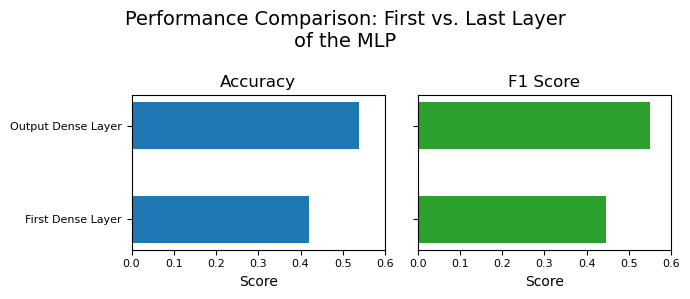

In [33]:
# Values for the bar plots
models = ['First Dense Layer', 'Output Dense Layer']
accuracy = [0.421, 0.539]
f1_score = [0.445, 0.551]

fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

# Plotting accuracy
ax[0].barh(models, accuracy, color='tab:blue', height=0.5)
ax[0].set_title('Accuracy', fontsize=12)
ax[0].set_xlim(0, 0.6)

# Plotting F1 score
ax[1].barh(models, f1_score, color='tab:green', height=0.5)
ax[1].set_title('F1 Score', fontsize=12)
ax[1].set_xlim(0, 0.6)

# Adding labels and fine-tuning the layout
for a in ax:
    a.set_xlabel('Score', fontsize=10)
    a.tick_params(axis='both', which='major', labelsize=8)

# Centering and breaking the title line
plt.suptitle('Performance Comparison: First vs. Last Layer\nof the MLP', fontsize=14)
plt.tight_layout()

plt.show()


In [81]:
# Define the sweep for each classifier and each descriptor
sweep_configuration = {
    "method": "bayes",
    "name": "sweep-svm-mlp",
    "program": 'code.py',
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        'classifier': {'value': 'svm'},
        'descriptor': {'value': 'mlp'},
        'n_folds': {'value': 5},
        'n_words': {'values': [64,256,512,1024]},
        'n_components': {'values': [8,16,32,64]},
        'C': {'value': 0.01},
        'fisher': {'value': False},
        'scaler': {'value': True},
        'kernel':  {'value': 'precomputed'},
        'patch_size': {'values': [16,32,64,128]},
        'overlap': {'values': [10,16]},
        'out_size': {'values': [256,512,1024,2048]},
        'num_layers': {'values': [2,4,8]},
        'activation': {'values': ['relu','tanh']},
    }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="bovw-mlp", entity="c3-mcv") # EJECUTAR UNA VEZ POR CLASIFICADOR Y DESCRIPTOR

Create sweep with ID: au5ybwnk
Sweep URL: https://wandb.ai/c3-mcv/bovw-mlp/sweeps/au5ybwnk
